This notebook is to find the minimized parameters over some dataset (ie, minimize least squares error)

In [119]:
# Imports 

import numpy as np
import pandas as pd

import iqplot
import bebi103

import bokeh.io
import bokeh.plotting

# bokeh.io.output_notebook()

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

import pandas as pd
import ast

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.themes import Theme
from bokeh.layouts import column, row

import scipy as sp
import matplotlib.pyplot as plt

# Plotting params
size = 500;

import numpy as np 
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
import sys
import os
import pandas as pd
import bebi103
import iqplot
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import copy

import numpy as np
from scipy.optimize import minimize



Loading BokehJS ...

In [120]:
# Read data 

data_location = '../../analyzed_data/atp-hydro/ATP.csv';
# Read the CSV file into a DataFrame
df1 = pd.read_csv(data_location); 

data_location = '../../analyzed_data/atp-hydro/ADP.csv';
# Read the CSV file into a DataFrame
df2 = pd.read_csv(data_location); 

data_location = '../../analyzed_data/atp-hydro/Phosphate.csv';
# Read the CSV file into a DataFrame
df3 = pd.read_csv(data_location); 

#### ------------- Load and Read Data ------------- ####
ATP_conc_list = []
ADP_conc_list = []
P_conc_list = []
ATP_curve_list = []
ratio_curve_list = []
linear_r2_list = []
exponential_r2_list = []
linear_hydrolysis_rate_list = []
exponential_hydrolysis_rate_list = []
times_list = []
data_locations_list = []

# for df in [df1]:
# for df in [df1, df2, df3]:
for df in [df1, df2]:  # without phosphate data
    # ATP Concentrations
    ATP_conc_list.append(np.array(df["ATP Concentration (uM)"])); 

    # ADP Concentrations
    ADP_conc_list.append(np.array(df["ADP Concentration (uM)"])); 

    # Phosphate Concentrations
    P_conc_list.append(np.array(df["P Concentration (uM)"])); 

    # ATP Curves
    ATP_curve_list.append([ast.literal_eval(df["ATP Curve (uM)"][i]) for i in range(len(df))])

    # Ratio Curves
    ratio_curve_list.append([ast.literal_eval(df["Ratio (A.U.)"][i]) for i in range(len(df))])

    # Goodness of Fit
    linear_r2_list.append(np.array(df["r-squared for linear fit"])); 
    exponential_r2_list.append(np.array(df["r-squared for exponential fit"])); 

    # Hydrolysis Rate
    linear_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Linear Fitting (-abs(Slope)/Motconc)"])); 
    exponential_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Exponential Curve"])); 

    # Time
    times_list.append([ast.literal_eval(df["Time Array (s)"][i]) for i in range(len(df))])
    
    # Data location
    data_locations_list.append(df["Data Location"])

    
times_list = [item for sublist in times_list for item in sublist];
ATP_conc_list = [item for sublist in ATP_conc_list for item in sublist]; 
ADP_conc_list = [item for sublist in ADP_conc_list for item in sublist];
P_conc_list = [item for sublist in P_conc_list for item in sublist];
ATP_curve_list = [item for sublist in ATP_curve_list for item in sublist];
ratio_curve_list = [item for sublist in ratio_curve_list for item in sublist];
linear_r2_list = [item for sublist in linear_r2_list for item in sublist];
exponential_r2_list = [item for sublist in exponential_r2_list for item in sublist];
linear_hydrolysis_rate_list = [item for sublist in linear_hydrolysis_rate_list for item in sublist];
exponential_hydrolysis_rate_list = [item for sublist in exponential_hydrolysis_rate_list for item in sublist];
data_locations_list = [item for sublist in data_locations_list for item in sublist]; 

In [128]:
ATP_end = 5; # define noise floor
start_index = 2; # throw away first few points

estimation_data = []; 

p = figure(width = 400, height = 400)
p2 = figure(width = 400, height = 400)

for i, curve in enumerate(ATP_curve_list): 
                
    conditions = np.zeros(2); 
    
    #### Quality control of data
    
    # Get end index
    if len(np.where(np.array(curve) < ATP_end)[0]) != 0:
        end_index = np.where(np.array(curve) < ATP_end)[0][0]
    else: 
        end_index = -1
    
    # Curve should have enough points
    if len(np.array(curve[start_index:end_index])) > 5:

        # Later atp measurements should not exceed initial atp measurement
        if np.all(np.array(curve[start_index + 1:]) < curve[start_index]): 

            conditions[0] = 1;
        
            # Ensure initial ATP isn't too high
            if curve[start_index] < ATP_conc_list[i]:
                conditions[1] = 1;
        
                # # If all criteria is met
                # plt.figure(figsize = (3, 3))
                # plt.plot(range(len(curve[start_index:end_index])), curve[start_index:end_index])
                # plt.show()

                # Append data
                estimation_data.append({
                    "atp": np.array(curve[start_index:end_index]), 
                    "time": np.array(times_list[i])[start_index:end_index],
                    "atp0": ATP_conc_list[i],
                    "adp0": ADP_conc_list[i],
                    "p0": P_conc_list[i],
                })

                p.line(np.array(times_list[i])[start_index:end_index]/60, np.log(np.array(curve[start_index:end_index])))
                p2.line(np.array(times_list[i])[start_index:end_index]/60, np.array(curve[start_index:end_index]))
            
show(gridplot([[p, p2]]))

data = pd.DataFrame(estimation_data)

In [122]:
df

Unnamed: 0                                      Data Location  \
0            0  /Volumes/Najma/ADP/1_ADP_variation_at_50uMATP/...   
1            1  /Volumes/Najma/ADP/1_ADP_variation_at_50uMATP/...   
2            2  /Volumes/Najma/ADP/1_ADP_variation_at_50uMATP/...   
3            3  /Volumes/Najma/ADP/1_ADP_variation_at_50uMATP/...   
4            4  /Volumes/Najma/ADP/1_ADP_variation_at_50uMATP/...   
..         ...                                                ...   
89          89  /Volumes/Najma/ADP/3_ADP_variation_at_100uMATP...   
90          90  /Volumes/Najma/ADP/3_ADP_variation_at_100uMATP...   
91          91  /Volumes/Najma/ADP/3_ADP_variation_at_100uMATP...   
92          92  /Volumes/Najma/ADP/3_ADP_variation_at_100uMATP...   
93          93  /Volumes/Najma/ADP/3_ADP_variation_at_100uMATP...   

    ATP Concentration (uM)  ADP Concentration (uM)  P Concentration (uM)  \
0                       50                       0                     0   
1                       50                    1000                     0   
2                       50                     100                     0   
3                       50                    1420                     0   
4                       50                     200                     0   
..                     ...                     ...                   ...   
89                     100                     200                     0   
90                     100                     300                     0   
91                     100                     470                     0   
92                     100                    5000                     0   
93                     100                     800                     0   

    NCD Micro Motor Concentration (uM)  r-squared for exponential fit  \
0                                    1                            NaN   
1                                    1                            NaN   
2                                    1                       0.754104   
3                                    1                            NaN   
4                                    1                       0.927657   
..                                 ...                            ...   
89                                   1                       0.917834   
90                                   1                       0.967146   
91                                   1                            NaN   
92                                   1                            NaN   
93                                   1                            NaN   

         Tau (s)       A0 (uM)     Ainf (uM)  ...  \
0    1093.500479  2.111713e+02  5.828678e-34  ...   
1    2364.823198  6.011800e+01  4.782877e+01  ...   
2     711.092626  2.140919e+01  1.399555e-01  ...   
3   59633.850075  3.941910e+01  8.847665e-09  ...   
4    1353.228443  2.644230e+01  1.477800e+00  ...   
..           ...           ...           ...  ...   
89   1201.095850  4.735319e+01  1.292470e-26  ...   
90   1964.848668  6.163821e+01  3.924161e+00  ...   
91    248.996674  1.673950e+06  1.538587e+02  ...   
92     51.459189  2.967416e+03  1.353925e+02  ...   
93   3823.089367  8.458276e+01  2.710705e+01  ...   

                        Cal_Param [Km, Rmax, Rmin, n]  Frame Interval (s)  \
0   [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
1   [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
2   [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
3   [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
4   [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
..                                                ...                 ...   
89  [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
90  [67.60201128, 3.36417414, 1.06783864, 1.17289855]                  20   
91  [67.60201128, 3.36417414, 1.06783864, 1.17289855]  

### Data Selection

In [129]:
# Prepare data
# remove_indices = [12, 26, 27, 46]; # manually select curves to not include
remove_indices = []; 

atp_array = []; 
ytau_array = []; 
atp0_array = []; 
adp0_array = []; 
p0_array = []; 
time_array = []; 
size_array = []; 

j = 0; 
for i, row in data.iterrows():
    if i not in remove_indices: 
        # if row["atp"][0]>500: 
            if len(row["time"]) > 5:
                atp_array.append(row["atp"])
                ytau_array.append(row["atp"][0])
                atp0_array.append(row["atp0"])
                adp0_array.append(row["adp0"])
                p0_array.append(row["p0"])
                time_array.append(row["time"])
                size_array.append(len(row["atp"])); 
                
                j+=1; 

                # if j > 0: 
                #     break
print(len(atp_array))

58


### Least Square Optimisation using Lambert function 

In [ ]:

# Define function for theoretical atp 
def theoretical_atp(params, time, y_data, atp0):
    # Extracting parameters
    keff, ktime, tau = params
    
    # # Model prediction
    # y_pred = np.zeros(len(time) + 1); 

    # # # Account for initial condition
    # x = (atp0/keff)*np.exp(atp0/keff); # lambert argument
    # y_pred[0] = keff*sp.special.lambertw(x).real; 
    # # y_pred[0] = atp0; 

    # Shift remaining time 
    shifted_time = time + tau; 
    x = (atp0/keff)*np.exp(atp0/keff - shifted_time/ktime); # lambert argument
    y_pred = keff*sp.special.lambertw(x).real; 

    return y_pred
    

# Define the function for least squares optimization
def least_squares(params, time, y_data, atp0):
    y_pred = theoretical_atp(params, time, y_data, atp0); 
    
    # Calculating residual (difference between predicted and actual values)
    residual = y_pred - y_data
    
    # Calculating the sum of squares of the residual
    ss_residual = np.sum(residual ** 2)
    
    # # Penalise for tau
    # tau = params[2]; 
    # ss_residual += (tau/60)**2; 
    return ss_residual

# Example data


# Initial guess for parameters
initial_guess = [1000, 10000, 300]

keff_optimized_array = np.zeros(len(atp_array)); 
ktime_optimized_array = np.zeros(len(atp_array)); 
tau_optimized_array = np.zeros(len(atp_array)); 

for i in range(len(atp_array)): 
    y_data = atp_array[i]
    time = time_array[i]

    # Perform optimization
    result = minimize(least_squares, initial_guess, args=(time, y_data, atp0_array[i]), tol=1e-6)

    # Extract optimized parameters
    keff_optimized, ktime_optimized, tau_optimized = result.x

    # # Print results
    # print("Optimized parameters:")
    # print("keff =", keff_optimized)
    # print("ktime =", ktime_optimized)
    # print("tau =", tau_optimized)

    # Store results
    keff_optimized_array[i] = keff_optimized; 
    ktime_optimized_array[i] = ktime_optimized; 
    tau_optimized_array[i] = tau_optimized; 
    
    # # Plot results
    # p = figure(); 
    # p.line(time, y_data, color = "blue")
    # p.line(time, theoretical_atp(result.x, time, y_data, atp0_array[i]), color = "orange")
    # show(p)



### Plot optimal parameter distributions

In [ ]:
print(
    """
Keff = [{0:.5f}, {1:.5f}, {2:.5f}]
""".format(
        *np.percentile(keff_optimized_array, [10, 50, 90])
    )
)

print(
    """
Ktime = [{0:.5f}, {1:.5f}, {2:.5f}]
""".format(
        *np.percentile(ktime_optimized_array, [10, 50, 90])
    )
)

print(
    """
Tau = [{0:.5f}, {1:.5f}, {2:.5f}]
""".format(
        *np.percentile(tau_optimized_array, [10, 50, 90])
    )
)

In [ ]:
show(iqplot.ecdf(keff_optimized_array, title = "Optimal Keff"))
show(iqplot.ecdf(ktime_optimized_array, title = "Optimal Ktime"))
show(iqplot.ecdf(tau_optimized_array, title = "Optimal Tau"))



The tau value range is huge - red flag! 

Let's have a look at the fits:

In [ ]:
for i in range(len(atp_array)): 
    if tau_optimized_array[i]< 900:
        y_data = atp_array[i]
        time = time_array[i]

        # Extract optimized parameters
        keff_optimized = keff_optimized_array[i]; 
        ktime_optimized = ktime_optimized_array[i]; 
        tau_optimized = tau_optimized_array[i]; 

        # # Print results
        # print("Optimized parameters:")
        # print("keff =", keff_optimized)
        # print("ktime =", ktime_optimized)
        # print("tau =", tau_optimized)
        p = figure(title = f"{i}, tau = {tau_optimized/60} min, atp0 = {atp0_array[i]}"); 
        # Plot results
        p.line(time/60, y_data, color = "blue")
        p.line(time/60, theoretical_atp([keff_optimized, ktime_optimized, tau_optimized], time, y_data, atp0_array[i]), color = "orange")

        p.xaxis.axis_label = "time (mins)"
        show(p)
    
# p = figure(title = "Tau < 0"); 
# for i in range(len(atp_array)): 
#     if tau_optimized_array[i]<0:
#         y_data = atp_array[i]
#         time = time_array[i]

#         # Extract optimized parameters
#         keff_optimized = keff_optimized_array[i]; 
#         ktime_optimized = ktime_optimized_array[i]; 
#         tau_optimized = tau_optimized_array[i]; 

#         # # Print results
#         # print("Optimized parameters:")
#         # print("keff =", keff_optimized)
#         # print("ktime =", ktime_optimized)
#         # print("tau =", tau_optimized)

#         # Plot results
#         p.line(time, y_data, color = "blue")
#         p.line(time, theoretical_atp([keff_optimized, ktime_optimized, tau_optimized], time, y_data), color = "orange")
# show(p)
    


In [ ]:
# Define the function for least squares optimization
def least_squares(params, Keff, atp0_array, adp0_array):
    C1, C2 = params; 

    Keff_pred = C1 + C2*(atp0_array + adp0_array); 
    
    # Calculating residual (difference between predicted and actual values)
    residual = Keff_pred - Keff
    
    # Calculating the sum of squares of the residual
    ss_residual = np.sum(residual ** 2)
    
    return ss_residual

# Selected Data 
# indices = np.where((tau_optimized_array < 1000)*(np.array(atp0_array) + np.array(adp0_array) < 800))[0]
indices = np.where(tau_optimized_array < 1000)[0]
print(indices)

# Initial guess for parameters
initial_guess = [10, 10]

# Specify bounds 
bounds = ((0, None), (0, None))
# bounds = ((None, None), (None, None))

# Perform optimization
result = minimize(least_squares, 
                  initial_guess, 
                  args=(keff_optimized_array[indices], np.array(atp0_array)[indices], np.array(adp0_array)[indices]), 
                  tol=1e-6, 
                  bounds = bounds,
                  method='COBYLA')

# Extract optimized parameters
C1_optimized, C2_optimized = result.x

# Print results
print("results: ", result)
print("Optimized parameters:")
print("C1 =", C1_optimized)
print("C2 =", C2_optimized)

p = figure(title = "Keff vs atp0 + adp0")

p.circle(keff_optimized_array[indices], np.array(atp0_array)[indices] + np.array(adp0_array)[indices])

keff_theoretical = C1_optimized + C2_optimized*(np.array(atp0_array)[indices] + np.array(adp0_array)[indices]); 
p.circle(keff_theoretical, np.array(atp0_array)[indices] + np.array(adp0_array)[indices], color = "orange")
show(p)

# Transform into KT, KD
KD_estimate = C1_optimized/C2_optimized; 
KT_estimate = 1/((1/C1_optimized) + (1/KD_estimate))



In [ ]:
# Initial guess for parameters
initial_guess = [100, 10]

# Specify bounds 
bounds = ((0, None), (0, None))

# Perform optimization
result = minimize(least_squares, initial_guess, args=(ktime_optimized_array, np.array(atp0_array), np.array(adp0_array)), tol=1e-6, bounds = bounds, method='trust-constr')

# Extract optimized parameters
D1_optimized, D2_optimized = result.x

# Print results
print("results: ", result)
print("Optimized parameters:")
print("D1 =", D1_optimized)
print("D2 =", D2_optimized)


p = figure(title = "Ktime vs atp0 + adp0")

p.circle(ktime_optimized_array, np.array(atp0_array) + np.array(adp0_array))

ktime_theoretical = D1_optimized + D2_optimized*(np.array(atp0_array) + np.array(adp0_array)); 
p.circle(ktime_theoretical, np.array(atp0_array) + np.array(adp0_array), color = "orange")

show(p)

# Transform into KT, KD
KD_estimate = C1_optimized/C2_optimized; 
KT_estimate = 1/((1/C1_optimized) + (1/KD_estimate))

gamma_estimate = KT_estimate/(D2_optimized*KD_estimate); 
print(f"Estimated KT: {KT_estimate} uM")
print(f"Estimated KD: {KD_estimate} uM")
print(f"Estimated gamma: {gamma_estimate} ATPs/motor/s")


The fits seem mostly reasonable. How do we reconcile with the huge tau (ie, time delay) values? 
Note that these seem consistent with the data - note that for alot of the experimental curves, the half-decay time is on the scale of hours! 

Perhaps our initial atp concentrations are not the same as the true value - this could be somewhat believable given human error and small pipetting values. 

Below, we reformulate the optimisation by only relying on y(tau), and ignoring y(0). 

Note that this implies we no longer have a time delay parameter tau. This is because the time difference = tau - (t + tau) = -t!

## New Model - No $\tau$

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define function for theoretical atp 
def theoretical_atp(params, time, y_data):
    # Extracting parameters
    keff, ktime = params
    
    # # Model prediction
    x = (y_data[0]/keff)*np.exp(y_data[0]/keff - (time - time[0])/ktime); # lambert argument
    y_pred = keff*sp.special.lambertw(x).real; 

    return y_pred
    

# # Define the function for least squares optimization
# def least_squares(params, time, y_data):
#     keff, ktime = params
#     lhs = (y_data/keff) * np.exp(y_data/keff); 
#     rhs = (y_data[0]/keff) * np.exp((y_data[0]/keff) - (time/ktime))
    
#     # Calculating residual (difference between predicted and actual values)
#     residual = (lhs - rhs)**2
    
#     # Calculating the sum of squares of the residual
#     ss_residual = np.sum(residual)*1e5

#     # print("ss_residual ", ss_residual)
    
#     return ss_residual


def least_squares(params, time, y_data):
    y_pred = theoretical_atp(params, time, y_data); 
    
    # Calculating residual (difference between predicted and actual values)
    residual = np.abs(y_pred - y_data)
    
    # Calculating the sum of squares of the residual
    ss_residual = np.sum(residual ** 2)/len(residual)

    # print("ss_residual ", ss_residual)
    
    return ss_residual



# Initial guess for parameters
initial_guess = [1000, 10000]

keff_optimized_array = np.zeros(len(atp_array)); 
ktime_optimized_array = np.zeros(len(atp_array)); 
# tau_optimized_array = np.zeros(len(ATP_curve_list)); 

for i in range(len(atp_array)): 
    y_data = atp_array[i]
    time = time_array[i]

    # Perform optimization
    result = minimize(least_squares, initial_guess, args=(time, y_data), tol=1e-6)
    # print(result)

    if result.success == False: 
        print(result)

    # Extract optimized parameters
    keff_optimized, ktime_optimized = result.x

    # # Print results
    # print("Optimized parameters:")
    # print("keff =", keff_optimized)
    # print("ktime =", ktime_optimized)
    # print("tau =", tau_optimized)

    # Store results
    keff_optimized_array[i] = keff_optimized; 
    ktime_optimized_array[i] = ktime_optimized; 
    # tau_optimized_array[i] = tau_optimized; 
    
    # Plot results
    p = figure(); 
    p.line(time, y_data, color = "blue")
    p.line(time, theoretical_atp(result.x, time, y_data), color = "orange")
    show(p)
    # break



In [ ]:
print(
    """
Keff = [{0:.5f}, {1:.5f}, {2:.5f}]
""".format(
        *np.percentile(keff_optimized_array, [10, 50, 90])
    )
)

print(
    """
Ktime = [{0:.5f}, {1:.5f}, {2:.5f}]
""".format(
        *np.percentile(ktime_optimized_array, [10, 50, 90])
    )
)

show(iqplot.ecdf(keff_optimized_array, title = "Optimal Keff"))
show(iqplot.ecdf(ktime_optimized_array, title = "Optimal Ktime"))

p = figure(title = "Keff vs Ktime")
p.circle(keff_optimized_array, ktime_optimized_array)
show(p)



In [ ]:
for i in range(len(atp_array)): 
    if keff_optimized_array[i]< 50:
        y_data = atp_array[i]
        time = time_array[i]

        # Extract optimized parameters
        keff_optimized = keff_optimized_array[i]; 
        ktime_optimized = ktime_optimized_array[i]; 

        p = figure(title = f"{i}, atp0 = {atp0_array[i]}"); 
        # Plot results
        p.line(time/60, y_data, color = "blue")
        p.line(time/60, theoretical_atp([keff_optimized, ktime_optimized], time, y_data), color = "orange")

        p.xaxis.axis_label = "time (mins)"
        show(p)
   

### Estimating constants from Keff, Ktime and initial atp, adp, and phosphate concentrations

#### Estimate KT, KD from Keff

In [ ]:
# Define the function for least squares optimization
def least_squares(params, Keff, atp0_array, adp0_array):
    C1, C2 = params; 

    Keff_pred = C1 + C2*(atp0_array + adp0_array); 
    
    # Calculating residual (difference between predicted and actual values)
    residual = Keff_pred - Keff
    
    # Calculating the sum of squares of the residual
    ss_residual = np.sum(residual ** 2)
    
    return ss_residual

# Example data


# Initial guess for parameters
initial_guess = [100, 100]

# Perform optimization
atp0_array_alternate = [y[0] for y in atp_array]; 
result = minimize(least_squares, initial_guess, args=(keff_optimized_array, np.array(atp0_array_alternate), np.array(adp0_array)), tol=1e-6)

# Extract optimized parameters
C1_optimized, C2_optimized = result.x

# Print results
print("results: ", result)
print("Optimized parameters:")
print("C1 =", C1_optimized)
print("C2 =", C2_optimized)

p = figure(title = "Keff vs atp0 + adp0")

p.circle(keff_optimized_array, np.array(atp0_array) + np.array(adp0_array))

keff_theoretical = C1_optimized + C2_optimized*(np.array(atp0_array) + np.array(adp0_array)); 
p.line(keff_theoretical, np.array(atp0_array) + np.array(adp0_array), color = "orange")
show(p)

In [ ]:
atp0_sum_adp0 = np.array(atp0_array) + np.array(adp0_array)

averaged_keff = []
std_keff = []
summed_axis_values = []; 

for i, summed_ic in enumerate(list(set(atp0_sum_adp0))): 
    print(np.std(keff_optimized_array[np.where(atp0_sum_adp0 == summed_ic)]))
    if np.std(keff_optimized_array[np.where(atp0_sum_adp0 == summed_ic)]) < 20000: 
        averaged_keff.append(np.mean(keff_optimized_array[np.where(atp0_sum_adp0 == summed_ic)]))
        std_keff.append(np.std(keff_optimized_array[np.where(atp0_sum_adp0 == summed_ic)]))
        summed_axis_values.append(summed_ic); 

averaged_keff = np.array(averaged_keff); 
std_keff = np.array(std_keff); 
summed_axis_values = np.array(summed_axis_values); 

p = figure()
p.circle(averaged_keff, summed_axis_values)
p.circle(averaged_keff + std_keff, summed_axis_values, color = "black")
p.circle(averaged_keff - std_keff, summed_axis_values, color = "black")

show(p)

In [ ]:
# Initial guess for parameters
initial_guess = [100, 10]

# Perform optimization
atp0_array_alternate = [y[0] for y in atp_array]; 
bounds = ((0, np.inf), (0, np.inf))
result = minimize(least_squares, initial_guess, args=(ktime_optimized_array, np.array(atp0_array_alternate), np.array(adp0_array)), tol=1e-6, bounds = bounds)

# Extract optimized parameters
D1_optimized, D2_optimized = result.x

# Print results
print("results: ", result)
print("Optimized parameters:")
print("D1 =", D1_optimized)
print("D2 =", D2_optimized)


p = figure(title = "Ktime vs atp0 + adp0")

p.circle(ktime_optimized_array, np.array(atp0_array) + np.array(adp0_array))

ktime_theoretical = D1_optimized + D2_optimized*(np.array(atp0_array) + np.array(adp0_array)); 
p.line(ktime_theoretical, np.array(atp0_array) + np.array(adp0_array), color = "orange")

show(p)


In [ ]:
# Transform into KT, KD
KD_estimate = C1_optimized/C2_optimized; 
KT_estimate = 1/((1/C1_optimized) + (1/KD_estimate))

gamma_estimate = KT_estimate/(D2_optimized*KD_estimate); 
print(f"Estimated KT: {KT_estimate} uM")
print(f"Estimated KD: {KD_estimate} uM")
print(f"Estimated gamma: {gamma_estimate} ATPs/motor/s")


## One Step Optimisation 

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define function for theoretical atp 
def theoretical_atp(params, time, y_data, atp0, adp0):
    # Extracting parameters
    C1, KD, gamma = params; 
    KT = 1/((1/C1) + (1/KD)); 

    m = 1; # motor concentration in uM

    # if changing to measured initial conditions
    atp0 = y_data[0]; 
    
    keff = (1 + (atp0 + adp0)/KD)/((1/KT) - (1/KD)); 
    ktime = KT*(1 + (atp0 + adp0)/KD)/(gamma*m); 
    
    # # Model prediction
    x = (y_data[0]/keff)*np.exp(y_data[0]/keff - (time - time[0])/ktime); # lambert argument
    y_pred = keff*sp.special.lambertw(x).real; 

    return y_pred
    

def least_squares(params, one_step_optimisation_data):
    atp0_array, adp0_array, atp_array, time_array = one_step_optimisation_data; 

    ss_residual = 0; 
    for atp0, adp0, y_data, time in zip(atp0_array, adp0_array, atp_array, time_array): 
        y_pred = theoretical_atp(params, time, y_data, atp0, adp0); 
    
        # Calculating residual (difference between predicted and actual values)
        residual = np.abs(y_pred - y_data)
    
        # Calculating the sum of squares of the residual
        ss_residual += np.sum(residual ** 2)/len(residual)

    # print("ss_residual ", ss_residual)
    
    return ss_residual



# Initial guess for parameters
initial_guess = [100, 100, 0.5]

keff_optimized_array = np.zeros(len(atp_array)); 
ktime_optimized_array = np.zeros(len(atp_array)); 
# tau_optimized_array = np.zeros(len(ATP_curve_list)); 

# one_step_optimisation_data = [(atp0, adp0, y, time) for atp0, adp0, y, time in zip(atp0_array, adp0_array, atp_array, time_array)]
one_step_optimisation_data = [atp0_array, adp0_array, atp_array, time_array]

bounds = ((10, 1000), (10, 1000), (0.001, 1))
result = minimize(least_squares, initial_guess, args=(one_step_optimisation_data), tol=1e-6, bounds = bounds); 
print(result)
# print("Optimized parameters:")
# print("keff =", keff_optimized)
# print("ktime =", ktime_optimized)
# print("tau =", tau_optimized)

C1_optimized, KD_optimized, gamma = result.x
KT_optimized = 1/((1/C1_optimized) + (1/KD_optimized)); 

print("Optimized parameters:")
print("KT_optimized =", KT_optimized)
print("KD_optimized =", KD_optimized)
print("gamma =", gamma)


for i in range(len(atp_array)): 
    y_data = atp_array[i]
    time = time_array[i]
    atp0 = atp0_array[i]
    adp0 = adp0_array[i]

    # Plot results
    p = figure(); 
    p.line(time, y_data, color = "blue")
    p.line(time, theoretical_atp(result.x, time, y_data, atp0, adp0), color = "orange")
    show(p)
    # break



## Optimising on $\frac{dA}{dt}$ dataset

We can also directly optimise paramters subject to the equation: 

\begin{align}
    \frac{dATP}{dt} = -\gamma m \frac{\frac{ATP}{K_T}}{1 + \frac{ATP}{K_T} + \frac{ADP}{K_D}}
\end{align}

Begin by noting that taking the differential directly on the ATP curves results in very noisy curves, as expected: 

In [6]:
p = figure(title = "Direct Differential")

for time, atp in zip(time_array, atp_array): 
    p.line(time[:-1], -np.diff(atp))

show(p)

We could consider our initial curves and fit polynomials that capture the mean behavior well. Then, we work with these polynomials for further optimisation. 

In [32]:
p = figure(width = 300, height = 300);
p2 = figure(width = 300, height = 300);

polynomial_data_list = []; 
for time, atp in zip(time_array, atp_array): 
    polynomial_fit = np.polyfit(time, atp, deg = 10); 
    pol = np.poly1d(polynomial_fit); 
    poly_der = np.polyder(pol)
    polynomial_data_list.append(-poly_der(time)); 
    
    p.line(time, atp, color = "orange", line_dash = "dashed", legend_label = "Experimental Data")
    p.line(time, pol(time), color = "black", legend_label = "Polynomial Fit")

    p2.line(time, -poly_der(time), legend_label = "Polynomial Fit")

show(gridplot([[p, p2]]))
    

/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_87280/1812720280.py:6: RankWarning: Polyfit may be poorly conditioned
  polynomial_fit = np.polyfit(time, atp, deg = 10);
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_87280/1812720280.py:6: RankWarning: Polyfit may be poorly conditioned
  polynomial_fit = np.polyfit(time, atp, deg = 10);
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_87280/1812720280.py:6: RankWarning: Polyfit may be poorly conditioned
  polynomial_fit = np.polyfit(time, atp, deg = 10);


Or, we could work with gaussian smoothed versions of the data

In [8]:
def gaussian_smoothing(data, rounds = 1, sigma = 1): 
    for _ in range(rounds): 
        data = sp.ndimage.gaussian_filter(data, sigma = sigma, mode = "nearest"); 

    return data


p = figure(width = 300, height = 300);
p2 = figure(width = 300, height = 300);

for time, atp in zip(time_array, atp_array): 
    smooth_data = gaussian_smoothing(atp, rounds = 20, sigma = 1); 
    p.line(time, atp, color = "orange", line_dash = "dashed", legend_label = "Experimental Data")
    p.line(time, smooth_data, color = "black", legend_label = "Polynomial Fit")

    p2.line(time[:-1], -np.diff(smooth_data), legend_label = "Gaussian Smoothing")

show(gridplot([[p, p2]]))
    


As a first pass, let's work with the polynomial data. 

In [35]:
def least_squares(params, data):
    C1, KD, gamma = params; 

    KT = 1/((1/C1) + (1/KD))
    m = 1; 
    experimental_rate, experimental_atp, experimental_atp0 = data; 

    ss_residual = 0; 
    for rate, atp, atp0 in zip(experimental_rate, experimental_atp, experimental_atp0): 
        theoertical_dA_dt = gamma*m*(atp/KT)/(1 + (atp0/KD) + (atp/C1)); 
        ss_residual += np.sum((rate - theoertical_dA_dt)**2); 

    # print("ss_residual ", ss_residual)
    return ss_residual



# Initial guess for parameters
initial_guess = [100, 100, 0.5]

# one_step_optimisation_data = [(atp0, adp0, y, time) for atp0, adp0, y, time in zip(atp0_array, adp0_array, atp_array, time_array)]
opt_data = [polynomial_data_list, atp_array, atp0_array]; 

bounds = ((1, 1000), (1, 1000), (0.001, 5))
result = minimize(least_squares, initial_guess, args=(opt_data), tol=1e-6); 
print(result)
# print("Optimized parameters:")
# print("keff =", keff_optimized)
# print("ktime =", ktime_optimized)
# print("tau =", tau_optimized)

C1_optimized, KD_optimized, gamma = result.x
KT_optimized = 1/((1/C1_optimized) + (1/KD_optimized)); 

print("Optimized parameters:")
print("C1_optimized =", C1_optimized)
print("KT_optimized =", KT_optimized)
print("KD_optimized =", KD_optimized)
print("gamma =", gamma)


for i in range(len(polynomial_data_list)): 
    atp = atp_array[i]
    time = time_array[i]
    atp0 = atp0_array[i]
    adp0 = adp0_array[i]
    m = 1; 
    theoertical_dA_dt = gamma*m*(atp/KT_optimized)/(1 + (atp0/KD_optimized) + (atp/C1_optimized)); 
    # Plot results
    p = figure(); 
    p.line(time, polynomial_data_list[i], color = "blue")
    p.line(time, theoertical_dA_dt, color = "orange")
    show(p)
    break

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.2475272877188375
        x: [ 2.018e+04  6.850e+03  1.224e+00]
      nit: 41
      jac: [-1.073e-06  1.788e-06  8.497e-03]
 hess_inv: [[ 1.564e+01  2.254e-03  1.130e+00]
            [ 2.254e-03  7.578e-04  1.186e-07]
            [ 1.130e+00  1.186e-07  2.201e-01]]
     nfev: 292
     njev: 73
Optimized parameters:
C1_optimized = 20179.946019435898
KT_optimized = 5114.202832108019
KD_optimized = 6850.265254169034
gamma = 1.2244585711699298


## Fitting initial Data to Exponential 

In [6]:
def least_squares(params, data):
    B = params; 
    atp, time = data; 
    
    exponential_atp = np.log(atp[0]) - (time - time[0])/B; 

    ss_residual = np.sum((np.log(atp) - exponential_atp)**4); 

    return ss_residual

def optimize_exponential(opt_data, atp0): 
    atp_data, time_data = opt_data; 

    performance = []
    best_rsquare_index = 0; 
    best_rsquare_value = 0; 
    for n in np.arange(10, 100, 10):
        atp = atp_data[:n]; 
        time = np.array(time_data[:n]);
        opt_data = [atp, time]; 

        result = minimize(least_squares, initial_guess, args=(opt_data), tol=1e-6); 
        B_optimised = result.x; 

        atp_exp = atp[0]*np.exp(-(time - time[0])/B_optimised); 

        r_squared_value = 1 - (np.sum((atp - atp_exp)**2)/np.sum((atp - np.mean(atp))**2)); 

        if r_squared_value > best_rsquare_value: 
            best_rsquare_value = r_squared_value; 
            best_rsquare_index = n; 
        # A_optimised = atp[0]; 
        # param_array.append(result.x)
        performance.append({
            "atp0": atp0,
            "index": n, 
            "result": result, 
            "B_optimized": result.x, 
            "r_squared_value": r_squared_value
        }); 
        # print("Optimised B: ", B_optimised)

        # # Plot results
        # p = figure(title = "Exponential Fit", width = 300, height = 300); 
        # p.circle(time, np.log(atp), color = "blue")
        # p.line(time, np.log(atp[0])-(time - time[0])/B_optimised, color = "orange")
        # p.xaxis.axis_label = "Time (min)"

        # p2 = figure(title = "Experimental Data", width = 300, height = 300); 
        # p2.circle(time, atp, color = "blue")
        # atp_exp = atp[0]*np.exp(-(time - time[0])/B_optimised)

        # r_squared_value = 1 - (np.sum((atp - atp_exp)**2)/np.sum((atp - np.mean(atp))**2)); 
        # p2.line(time, atp_exp, color = "orange")
        # p2.xaxis.axis_label = "Time (min)"

        # show(gridplot([[p2, p]]))
    
    performance = pd.DataFrame(performance); 
    best_performance = performance[performance["index"] == best_rsquare_index]; 
    return pd.DataFrame(best_performance)

In [7]:
# Initial guess for parameters
initial_guess = [100]

performance_arrays = []

B_array = []; 

r_squared_values_array = []; 
for time_data, atp_data, atp0 in zip(time_array, atp_array, atp0_array): 
    # for n in np.arange(10, 50, 10):
        atp = atp_data; 
        time = np.array(time_data)/60; 
        opt_data = [atp, time]; 

        performance_array = optimize_exponential(opt_data, atp0); 
        B_optimised = performance_array["B_optimized"].values[0][0]; 
        index_optimised = performance_array["index"].values[0]; 
        r_squared_values = performance_array["r_squared_value"].values[0]; 

        print("Optimised B: ", B_optimised)

        performance_arrays.append(performance_array); 
        B_array.append(B_optimised)
        r_squared_values_array.append(r_squared_values); 

        # Plot results
        p = figure(title = "Exponential Fit", width = 300, height = 300); 
        p.circle(time, np.log(atp))
        p.line(time[:index_optimised], np.log(atp[0])-(time[:index_optimised] - time[0])/B_optimised, color = "orange")
        p.line(time[index_optimised:], np.log(atp[0])-(time[index_optimised:] - time[0])/B_optimised, color = "black")
        p.xaxis.axis_label = "Time (mins)"

        p2 = figure(title = f"ATP0: {atp0} uM, r2: {r_squared_values}", width = 300, height = 300); 
        p2.circle(time, atp)
        atp_exp = atp[0]*np.exp(-(time - time[0])/B_optimised)
        p2.line(time[:index_optimised], atp_exp[:index_optimised], color = "orange")
        p2.line(time[index_optimised:], atp_exp[index_optimised:], color = "black")
        p2.xaxis.axis_label = "Time (mins)"

        show(gridplot([[p2, p]]))
        # break

B_array = np.array(B_array)

Optimised B:  52.045945103632974


Optimised B:  56.19814257719642


Optimised B:  20.977903085118175


Optimised B:  28.421368410626425


Optimised B:  40.135140596276486


Optimised B:  50.65331346132363


Optimised B:  20.930816031219745


Optimised B:  29.20882407888529


Optimised B:  39.10048588357582


Optimised B:  92.61077893698454


Optimised B:  51.800961718406626


Optimised B:  93.58715353750866


Optimised B:  24.16430497206834


Optimised B:  27.65293443874456


Optimised B:  58.0804647732584


Optimised B:  100.0


Optimised B:  11.420751268291978


Optimised B:  19.802863544528233


Optimised B:  26.276857068354758


Optimised B:  47.027780497051396


Optimised B:  41.183449116119846


Optimised B:  47.09624925528488


Optimised B:  132.77264414460043


Optimised B:  58.74208273293794


Optimised B:  67.65665688621314


Optimised B:  77.39850905162386


Optimised B:  32.43620342368682


Optimised B:  27.071204035595976


Optimised B:  33.634806178703194


Optimised B:  32.0603370239657


Optimised B:  43.060401755529846


Optimised B:  63.37104149606394


Optimised B:  98.28770575021775


Optimised B:  50.21663853918323


Optimised B:  22.791230221933144


Optimised B:  38.18909622249283


Optimised B:  44.362827324940895


Optimised B:  60.163952448887635


Optimised B:  81.06902099860828


Optimised B:  32.09217219370604


Optimised B:  41.5939670459345


Optimised B:  24.567674519376517


Optimised B:  56.872605841269674


Optimised B:  178.10652676648425


Optimised B:  26.276857068354758


Optimised B:  12.029659189447226


Optimised B:  20.563138465543574


Optimised B:  155.84907946416553


Optimised B:  267.5542721215487


Optimised B:  100.0


Optimised B:  160.85336062429192


Optimised B:  12.359680139950406


Optimised B:  271.2253180239287


Optimised B:  20.284069123471788


Optimised B:  36.56084559699949


Optimised B:  100.0


In [113]:
len(atp0_array)

56

In [8]:
def generate_hex_color(value, min_value = 0, max_value = 500):
    """
    Generate a hexadecimal color based on the input value within a specified range.

    Args:
        value (float): Input value for color generation.
        min_value (float): Minimum value of the range.
        max_value (float): Maximum value of the range.

    Returns:
        str: Hexadecimal color code.
    """

    if value > max_value: 
        value = max_value; 
    # Normalize the value within the range
    normalized_value = (value - min_value) / (max_value - min_value)
    
    # Convert the normalized value to a color
    rgb_color = [int(x * 255) for x in plt.cm.viridis(normalized_value)[:3]]  # Use Viridis colormap, but you can change this to any other colormap

    # Convert RGB to hexadecimal color
    hex_color = "#{:02x}{:02x}{:02x}".format(*rgb_color)

    return hex_color

p1 = figure(title = "Cutoff vs ATP0", width = 300, height = 300); 
p2 = figure(title = "Cutoff vs ADP0", width = 300, height = 300); 
p3 = figure(title = "Timescale vs ATP0 + ADP0 + P0", width = 300, height = 300); 

p4 = figure(title = "Timescale vs ATP0", width = 300, height = 300); 
p5 = figure(title = "Timescale vs ADP0", width = 300, height = 300); 
p6 = figure(title = "Timescale vs P0", width = 300, height = 300); 
p7 = figure(title = "R square fit value vs ATP0", width = 300, height = 300); 


indices_selected = []; 

for i in range(len(B_array)): 
    B = B_array[i]; 
    r_squared_values = r_squared_values_array[i]; 
    atp = atp_array[i]; 
    atp0 = atp0_array[i]; 
    adp0 = adp0_array[i]; 
    p0 = p0_array[i]; 

    initial_atp_discrepancy = atp0 - atp[0]; 
    color = generate_hex_color(initial_atp_discrepancy)

    if initial_atp_discrepancy < 50:
        indices_selected.append(i)
    
    p3.circle(atp0 + adp0 + p0, B, color = color)

    p4.circle(atp0, B, color = color)

    p5.circle(adp0, B, color = color)

    p6.circle(adp0, B, color = color)

    p7.circle(atp0, r_squared_values, color = color)

# Create a color mapper
mapper = linear_cmap(field_name='values', palette=Viridis256, low=0, high=1)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0))
p3.add_layout(color_bar, 'right')

show(gridplot([[p3, p4], [p5, p6], [p7]]))

In [9]:
# Get coefficients from B (Keff) vs atp0, adp0, p0 graphs

def least_squares(params, data):
    C1, CD = params; 
    atp0_array, adp0_array, p0_array, B_array = data; 

    ss_residual = np.sum((C1 + CD*(atp0_array + adp0_array) - B_array)**2); 

    return ss_residual

opt_data = [atp0_array, adp0_array, p0_array, B_array]; 

initial_guess = [1, 1]; 

# bounds = [(0, 1000), (0, 1000)]

result = minimize(least_squares, initial_guess, args=(opt_data), tol=1e-6); 
C1, CD = result.x; 

print(result)

p = figure(title = "Keff vs ATP0 + ADP0", width = 300, height = 300); 
p2 = figure(title = "Keff vs ATP0 + P0", width = 300, height = 300); 

p.circle(atp0_array + adp0_array, B_array)
B_theory = C1 + CD*(atp0_array + adp0_array); 
p.line(atp0_array + adp0_array, B_theory)

p2.circle(atp0_array + adp0_array, B_array)
p2.circle(atp0_array + p0_array, B_theory, color = "darkorange")

show(gridplot([[p, p2]]))

print("KD value as a ratio of cuttoff/slope = ", C1/CD); 

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 101768.816975141
        x: [ 5.602e+00  7.083e-02]
      nit: 7
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 3.303e-02 -3.039e-05]
            [-3.039e-05  3.833e-08]]
     nfev: 24
     njev: 8


KD value as a ratio of cuttoff/slope =  79.09199266610047


## Fitting entire Dataset to Exponential 

In [17]:
def least_squares(params, data):
    B = params; 
    atp, time = data; 
    
    exponential_atp = np.log(atp[0]) - (time - time[0])/B; 

    ss_residual = np.sum((np.log(atp) - exponential_atp)**4); 

    return ss_residual

def optimize_exponential(opt_data, atp0): 
    atp_data, time_data = opt_data; 

    performance = []; 
    best_rsquare_value = 0; 
    atp = atp_data; 
    time = np.array(time_data);
    opt_data = [atp, time]; 

    result = minimize(least_squares, initial_guess, args=(opt_data), tol=1e-6); 
    B_optimised = result.x; 

    atp_exp = atp[0]*np.exp(-(time - time[0])/B_optimised); 

    r_squared_value = 1 - (np.sum((atp - atp_exp)**2)/np.sum((atp - np.mean(atp))**2)); 

    if r_squared_value > best_rsquare_value: 
        best_rsquare_value = r_squared_value; 
    # A_optimised = atp[0]; 
    # param_array.append(result.x)
    performance.append({
        "atp0": atp0,
        "result": result, 
        "B_optimized": result.x, 
        "r_squared_value": r_squared_value
    }); 
    
    return pd.DataFrame(performance)

In [20]:
# Initial guess for parameters
initial_guess = [100]

performance_arrays = []
B_array = []; 
r_squared_values_array = []; 

for time_data, atp_data, atp0 in zip(time_array, atp_array, atp0_array): 
    atp = atp_data; 
    time = np.array(time_data)/60; 
    opt_data = [atp, time]; 

    performance_array = optimize_exponential(opt_data, atp0); 
    B_optimised = performance_array["B_optimized"].values[0][0]; 
    r_squared_values = performance_array["r_squared_value"].values[0]; 

    print("Optimised B: ", B_optimised)

    performance_arrays.append(performance_array); 
    B_array.append(B_optimised)
    r_squared_values_array.append(r_squared_values); 

    # Plot results
    p = figure(title = "Exponential Fit", width = 300, height = 300); 
    p.circle(time, np.log(atp))
    p.line(time, np.log(atp[0])-(time - time[0])/B_optimised, color = "orange")
    p.xaxis.axis_label = "Time (mins)"

    p2 = figure(title = f"ATP0: {atp0} uM, r2: {r_squared_values}", width = 300, height = 300); 
    p2.circle(time, atp)
    atp_exp = atp[0]*np.exp(-(time - time[0])/B_optimised)
    p2.line(time, atp_exp, color = "orange")
    p2.xaxis.axis_label = "Time (mins)"

    show(gridplot([[p2, p]]))
    # break

B_array = np.array(B_array)

Optimised B:  157.6554429967626


Optimised B:  193.0391791484786


Optimised B:  20.697267997977598


Optimised B:  29.33092984994394


Optimised B:  50.1245321785598


Optimised B:  128.27829686774012


Optimised B:  20.930816031219745


Optimised B:  29.52896527484135


Optimised B:  49.34729979492234


Optimised B:  185.3947604794359


Optimised B:  129.11625046191685


Optimised B:  164.52017896951108


Optimised B:  24.16430497206834


Optimised B:  27.65293443874456


Optimised B:  72.15718051373631


Optimised B:  139.59850097581062


Optimised B:  11.420751268291978


Optimised B:  19.802863544528233


Optimised B:  28.909940273775803


Optimised B:  78.71604533632775


Optimised B:  38.632540451533664


Optimised B:  58.4293303735033


Optimised B:  294.0749474686657


Optimised B:  200.0542142016311


Optimised B:  161.5714251485661


Optimised B:  182.58949912032838


Optimised B:  67.04815773387138


Optimised B:  37.596282712316786


Optimised B:  46.35408699776703


Optimised B:  97.52134587617132


Optimised B:  158.64103852428502


Optimised B:  222.08127572424203


Optimised B:  322.1142819592748


Optimised B:  101.67865600050284


Optimised B:  49.441403421643436


Optimised B:  152.23831355262948


Optimised B:  191.46366816090801


Optimised B:  216.15644351996454


Optimised B:  299.3367877971964


Optimised B:  67.69481419650168


Optimised B:  97.31132675488003


Optimised B:  24.93014524714067


Optimised B:  70.9411891042081


Optimised B:  309.3708846457706


Optimised B:  28.909940273775803


Optimised B:  12.029659189447226


Optimised B:  20.563138465543574


Optimised B:  176.4617111905438


Optimised B:  288.3318445961421


Optimised B:  121.58469373387263


Optimised B:  181.72513875424417


Optimised B:  12.359680139950406


Optimised B:  295.96853006857225


Optimised B:  20.284069123471788


Optimised B:  39.091327325689875


Optimised B:  121.58469373387263


## Fitting a polynomial to log(ATP)

In [130]:
polynomial_coefficients_array = []; 
mean_square_error = np.zeros(len(atp_array))
for i in range(len(atp_array)): 
# for i in [27, 34, 33, 36, 37]: 
    print(i)
    time = np.array(time_array[i])/3600; 
    z = np.polyfit(time, np.log(atp_array[i]), 2, rcond=None, full=False, w=None, cov=False)
    print(z)
    polynomial_coefficients_array.append(z); 
    pol = np.poly1d(z); 

    # p1 = figure(title = fr"\[ATP0:{atp0_array[i]},\\log(ATP) = {round(z[0], 3)} t^2 + {round(z[1], 3)} t + {round(z[2], 3)}\] ", width = 350, height = 300)
    p1 = figure(width = 350, height = 300)

    p1.circle(time, np.log(atp_array[i]), legend_label = "Experimental Data")
    p1.line(time, pol(time), color = "darkorange", line_width = 2, legend_label = "Polynomial Fit")
    p1.yaxis.axis_label = "log[ATP] (uM)"
    p1.xaxis.axis_label = "Time (hrs)"

    p2 = figure(title = f"ATP0: {atp0_array[i]} uM", width = 350, height = 300)
    p2.circle(time, atp_array[i], legend_label = "Experimental Data")
    p2.line(time, np.exp(pol(time)), color = "darkorange", legend_label = "Polynomial Fit")
    p2.xaxis.axis_label = "Time (hrs)"
    p2.yaxis.axis_label = "ATP (uM)"

    # Calculate mean square error
    mean_square_error[i] = np.sum(np.abs(atp_array[i] - np.exp(pol(time))))/len(atp_array[i])

    # show(gridplot([[p2, p1]]))
    # break
    
polynomial_coefficients_array = np.array(polynomial_coefficients_array)

0
[ 0.02612566 -0.58848272  6.10419914]
1
[ 0.01229337 -0.37882406  6.03207837]
2
[-0.09731355 -2.82770301  4.82556895]
3
[ 0.27246794 -2.40968086  5.28663327]
4
[ 0.12760839 -1.40419543  5.5480465 ]
5
[ 0.0364662  -0.72497992  5.93616973]
6
[ 0.0565551  -2.91543832  4.85997453]
7
[ 0.18659475 -2.28740006  5.21874739]
8
[ 0.13309982 -1.4468215   5.59101954]
9
[ 0.02056888 -0.51233622  5.68049863]
10
[ 0.03437501 -0.7031575   5.92311974]
11
[ 0.01111549 -0.36250112  5.699491  ]
12
[-1.01270619 -4.57789088  3.03081122]
13
[ 0.88335158 -2.91237101  3.31790848]
14
[ 0.65121682 -2.45737238  3.39514452]
15
[ 0.21011074 -1.02223631  3.56424561]
16
[ 0.10682753 -0.49851266  3.60808566]
17
[ 1.45356711 -5.74112949  3.37464203]
18
[ 1.0973204  -3.5710418   3.73351325]
19
[ 0.73678507 -2.58197511  3.8096852 ]
20
[ 0.32867795 -1.38734679  3.96126844]
21
[ 0.16278694 -1.90837604  5.43381025]
22
[ 0.05395837 -0.83923564  4.89301369]
23
[ 0.0221155  -0.41311955  4.98833532]
24
[ 0.03632254 -0.6551655

In [131]:
mean_square_error

array([ 3.71368259,  8.23723799,  0.15480905,  0.77995393,  2.97638762,
        5.39661658,  0.19045247,  0.71210811,  2.45396885,  1.60040558,
        5.07085607,  4.14764612,  0.05648325,  0.10637296,  0.11537678,
        0.32104737,  0.40817868,  0.04527761,  0.09097537,  0.06010694,
        0.21520516,  2.4594832 ,  6.84576968,  9.25328025,  7.99210011,
        8.48209932, 13.8539349 ,  2.12697455,  5.00089211,  5.87730075,
        9.77576287,  7.45326986,  5.44322786,  5.52888228,  4.12605757,
       11.0901597 ,  8.45941091,  6.70951979,  5.92334598,  6.2185084 ,
        2.54654753,  3.82812714,  0.03198232,  0.09569473,  0.29069471,
        0.38241954,  0.06010694,  0.02702356,  0.095769  ,  0.27394155,
        0.37219545,  0.26369089,  0.30356418,  0.0149193 ,  0.35244349,
        0.09423302,  0.13915917,  0.26369089])

(array([14.,  7.,  6.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,
         2.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.0149193 ,  0.15330945,  0.29169961,  0.43008976,  0.56847992,
         0.70687008,  0.84526023,  0.98365039,  1.12204054,  1.2604307 ,
         1.39882086,  1.53721101,  1.67560117,  1.81399132,  1.95238148,
         2.09077164,  2.22916179,  2.36755195,  2.50594211,  2.64433226,
         2.78272242,  2.92111257,  3.05950273,  3.19789289,  3.33628304,
         3.4746732 ,  3.61306335,  3.75145351,  3.88984367,  4.028233

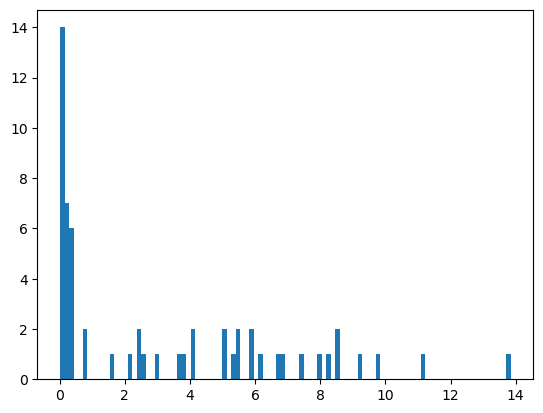

In [132]:
plt.hist(mean_square_error, bins = 100)

In [135]:
p = figure(title = "Mean Absolute Error across Experiments", width = 350, height = 300)
p.xaxis.axis_label = "Mean Absolute Error (uM)"
p.yaxis.axis_label = "Fraction of Experiments"
show(iqplot.ecdf(mean_square_error, p = p))

In [147]:
# p0 = figure(title = "t^3 coefficient", width = 300, height = 300)
p1 = figure(title = r"\[t^{2}\] coefficient", width = 300, height = 300)
p2 = figure(title = r"\[t^{1}\] coefficient", width = 300, height = 300)
p3 = figure(title = "Y-intercept", width = 300, height = 300)

for i in range(len(atp_array)): 
    # atp0_array[i] + adp0_array[i] + p0_array[i]
    # p0.circle(atp0_array[i] + adp0_array[i] + p0_array[i], polynomial_coefficients_array[i][0])
    p1.circle(atp0_array[i] + adp0_array[i] + p0_array[i], polynomial_coefficients_array[i][0])
    p2.circle(atp0_array[i] + adp0_array[i] + p0_array[i], polynomial_coefficients_array[i][1])
    p3.circle(atp0_array[i] + adp0_array[i] + p0_array[i], polynomial_coefficients_array[i][2])

p1.xaxis.axis_label = "ATP[0] + ADP[0] + P[0]"
p1.yaxis.axis_label = "beta2"

p2.xaxis.axis_label = "ATP[0] + ADP[0] + P[0]"
p2.yaxis.axis_label = "beta1"

p3.xaxis.axis_label = "ATP[0] + ADP[0] + P[0]"
p3.yaxis.axis_label = "beta0"

# show(gridplot([[p0, p1], [p2, p3]]))
show(gridplot([[p3, p2, p1]]))



## Fitting linear exp + logistic

In [ ]:
polynomial_coefficients_array = []; 

for i in range(len(atp_array)): 
    time = np.array(time_array[i])/3600; 
    z = np.polyfit(time, np.log(atp_array[i]), 2, rcond=None, full=False, w=None, cov=False)
    print(z)
    polynomial_coefficients_array.append(z); 
    pol = np.poly1d(z); 

    # p1 = figure(title = fr"\[ATP0:{atp0_array[i]},\\log(ATP) = {round(z[0], 3)} t^2 + {round(z[1], 3)} t + {round(z[2], 3)}\] ", width = 350, height = 300)
    p1 = figure(title = f"ATP0: {atp0_array[i]} uM", width = 350, height = 300)

    p1.line(time, np.log(atp_array[i]))
    p1.line(time, pol(time), color = "darkorange")

    p1.xaxis.axis_label = "Time (hrs)"

    p2 = figure(title = f"ATP vs Time", width = 350, height = 300)
    p2.line(time, atp_array[i])
    p2.line(time, np.exp(pol(time)), color = "darkorange")


    show(gridplot([[p1, p2]]))
    break
    
polynomial_coefficients_array = np.array(polynomial_coefficients_array)

# Archived:

#### Least Square Optimization 

Parameters to optimize over: $\theta = (\gamma, K_T, K_D, K_P)$

Given the transcendal nature of the LHS of the equation, we are going to reformulate the problem such that t = f(y). Intuitively, this should give us the same result as it's still the same problem $\textbf{CHECK!!!!}$

\begin{align}
t = f_{\theta}(y) = K_{time}(\,\, \frac{y(0) - y}{K_{eff}} + ln(\frac{y(0)}{y}) \,\,)
\end{align}

Where, 

\begin{align}
K_{eff} = \frac{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})}{\frac{1}{K_T} - \frac{1}{K_D} - \frac{1}{K_P}} \,,
\end{align}

\begin{align}
K_{time} = \frac{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})}{\gamma*m} \,,
\end{align}


In [ ]:
# Define function
Keff = lambda KT, KD, KP, y0, ADP0, P0: KT*(1 + (y0 + ADP0)/KD + (y0 + P0)/KP)/((1/KT) - (1/KD) - (1/KP));
Ktime = lambda KT, KD, KP, y0, ADP0, P0, gamma, m: KT*(1 + (y0 + ADP0)/KD + (y0 + P0)/KP)/(gamma*m);
theoretical_time = lambda y, K_eff, K_time, y0: K_time*((y0 - y)/K_eff + np.log(y0/y)) 


# def theoretical_time(y, K_eff, K_time, y0): 
#     if y0 > 0: 
#         t =  K_time*((y0 - y)/K_eff + np.log(y0/y)) 

#     else:
#         t =  K_time*(y0 - y)/K_eff # TODO: do not consider ATP0 = 0 conditions....

#     return t 

In [ ]:
# Plot theoretical curve for some parameter values; 
K_eff = Keff(KT = 50, KD = 50, KP = 9000, y0 = 1410, ADP0 = 0, P0 = 0)
K_time = Ktime(KT = 50, KD = 50, KP = 9000, y0 = 1410, ADP0 = 0, P0 = 0, gamma = 1, m = 1)

y = np.arange(1410, 10, -10)
times = theoretical_time(y, K_eff, K_time, y0 = 1410)

plt.scatter(y, times); 
plt.xlabel("ATP")
plt.ylabel("Time")


In [ ]:
# Define optimizer

def square_error(params, data, m = 1):
    '''
        Returns square error
    '''

    # ------ Load Data ------ #
    time_list, y_list, y0_list, ADP0_list, P0_list = data

    KT = params[0]; 
    KD = params[1];
    KP = params[2];
    gamma = params[3]; 

    shifted_time_list = copy.deepcopy(time_list)
    
    if len(params) > 4:
        delta_t = params[4:]; 
        # delta_t = params[4]; 

        # ------ Shift time points with delta_t ------ #
        for i in range(len(time_list)): 

            if len(delta_t) == 1:
                shifted_time_list[i][1:] += delta_t; # shift all points (except zero) with delta_t
            else: 
                shifted_time_list[i][1:] += delta_t[i]; # shift all points (except zero) with delta_t
        
    K_eff = Keff(KT, KD, KP, y0_list, ADP0_list, P0_list)
    K_time = Ktime(KT, KD, KP, y0_list, ADP0_list, P0_list, gamma, m);
    
    # ------ Calculate Error ------ #
    square_error = 0;
    for i in range(len(y_list)):
        # Ignore low ATP conditions and reject cases where too much ATP was hydrolyzed before data collection
        if y_list[i][0] > 100 and y_list[i][1]/y_list[i][0] > 0.3: 
            square_error += np.average((theoretical_time(y_list[i], K_eff[i], K_time[i], y0_list[i]) - shifted_time_list[i])**2)

    return np.log(square_error)

    
def optimize(minimizer, data, initial_guess, bounds = []): 
    """
        Takes an objective function (to be minimized), the data, and the initial guess.
        Returns minimized parameters.
    """
    # Specify extra arguments into posterior function
    args = (data,)
    
    # Specify min error to reach before declaring convergence 
    # convergence_checker = ConvergenceChecker(min_error = 10, data = data)
    
    # Compute the MAP
    res = scipy.optimize.minimize(
        minimizer, initial_guess, args=args, 
        method="Nelder-Mead", 
        # method="Powell",
        # options = {"ftol": 10}, 
        bounds = bounds
    )
    
    # # Compute the MAP
    # res = scipy.optimize.leastsq(
    #     minimizer, initial_guess, args=args,
    # )
    

    return res

#### Run Optimization

In [ ]:
# Select Data

truncated_ATP_curve_list = []
truncated_times_list = []
for i in range(len(ATP_curve_list)): 
    index = np.where(np.array(times_list[i]) >= 6000)[-1]; # get index
    if len(index) != 0: 
        truncated_times_list.append(times_list[i][:index[0]])
        truncated_ATP_curve_list.append(ATP_curve_list[i][:index[0]])

data = [
         truncated_times_list, 
         truncated_ATP_curve_list, 
         ATP_conc_list, 
         ADP_conc_list, 
         P_conc_list
        ]

# First guess
parameter_initial_guess = np.ones(4 + len(ATP_curve_list)); 
# parameter_initial_guess = np.ones(4 + 1); 
parameter_initial_guess[0] = 50; 
parameter_initial_guess[1] = 50; 
parameter_initial_guess[2] = 50; 

# Bounds on parameters
bounds = [(0, 5000), (0, 5000), (0, 5000), (0, 5)] + [(0, 1500)]*len(parameter_initial_guess[4:])

# Optimize all together
res = optimize(square_error, data, parameter_initial_guess, bounds = bounds)
print(res)
# popt = res[0]

# Extract optimal parameters
popt = res.x;
n_iterations = res.nit; # number of iterations performed by the optimizer
success = res.success; #whether optimization was successful 
    
print(
    "Optimization Details\n", 
    f"Success: {success} \n", 
    f"Number of Iterations: {n_iterations} \n", 
    f"Parameters: {popt} \n", 
    )


In [ ]:
# Visualising best fit
# KT, KD, KP, gamma, delta_t = popt; 

KT = popt[0]; 
KD = popt[1]; 
KP = popt[2]; 
gamma = popt[3]; 

if len(popt) > 4:
    delta_t = popt[4:]; 

for i in range(len(ATP_curve_list)):
    y0 = ATP_conc_list[i]; 
    
    # if y0 > 100: 
    if ATP_curve_list[i][0] > 100 and ATP_curve_list[i][1]/ATP_curve_list[i][0] > 0.3: 
        p = figure()
        # Data
        y = truncated_ATP_curve_list[i]; 
        times_plot = copy.deepcopy(truncated_times_list[i]);

        if len(popt) > 4: 

            if len(delta_t) == 1:
                print(delta_t)
                times_plot[1:] += delta_t
            else:
                times_plot[1:] += delta_t[i]
        p.circle(times_plot, y, legend_label = "Data") 
        
        # Theoretical Curve
        K_eff = Keff(KT, KD, KP, y0, ADP_conc_list[i], P_conc_list[i])
        K_time = Ktime(KT, KD, KP, y0, ADP_conc_list[i], P_conc_list[i], gamma = 1, m = 1);
        
        times_plot = theoretical_time(y, K_eff, K_time, y0 = y0)
        p.line(times_plot, y, legend_label = "Theoretical Curve")

        p.circle(0, y0, color = "red")
        show(p)

        # print(y0 == y[0])
        # print(times[:2])
# show(p)

## Two-Step Minimizaiton

In [ ]:
# Define optimizer
def two_step_square_error(params, data, m = 1):
    '''
        Returns square error
    '''

    # ------ Load Data ------ #
    time_list, y_list, y0_list, ADP0_list, P0_list = data

    KT = params[0]; 
    KD = params[1];
    KP = params[2];
    gamma = params[3]; 
        
    # K_eff = Keff(KT, KD, KP, y0_list, ADP0_list, P0_list)
    # K_time = Ktime(KT, KD, KP, y0_list, ADP0_list, P0_list, gamma, m);
    
    # ------ Calculate Error ------ #
    square_error = 0;
    for i in range(len(y_list)):
        K_eff = Keff(KT, KD, KP, y0_list[i], ADP0_list[i], P0_list[i])
        K_time = Ktime(KT, KD, KP, y0_list[i], ADP0_list[i], P0_list[i], gamma, m);

        # print('constants', K_eff, K_time)
        # Ignore low ATP conditions and reject cases where too much ATP was hydrolyzed before data collection

        if y_list[i][0] > 100 and y_list[i][1]/y_list[i][0] > 0.3: 
            square_error += np.average((theoretical_time(y_list[i], K_eff, K_time, y0_list[i]) - time_list[i])**2)
    print('square_error', square_error)
    # return np.log(square_error)
    return square_error

    
def two_step_optimize(minimizer, data, initial_guess, bounds = []): 
    """
        Takes an objective function (to be minimized), the data, and the initial guess.
        Returns minimized parameters.
    """
    # Specify extra arguments into posterior function
    args = (data,)
    
    # Compute the MAP
    res = scipy.optimize.minimize(
        minimizer, initial_guess, args=args, 
        method="Nelder-Mead", 
        # method="Powell",
        # options = {"ftol": 10}, 
        bounds = bounds
    )

    return res

In [ ]:
time_shifts = np.arange(0, 900, 60)

errors = np.zeros((len(time_shifts)))
optimal_params_list = np.zeros((len(time_shifts), 4))

lengths = [len(curve) for curve in ATP_curve_list]; 
min_length = min(lengths)
for j, delta_t in enumerate(time_shifts): 

    # -------- Shift time points -------- # 
    shifted_times_list = copy.deepcopy(times_list)
    for i in range(len(shifted_times_list)): 
        shifted_times_list[i][1:] += delta_t;
    # -------- Optimize -------- # 

    data = [
             [time[:min_length] for time in shifted_times_list], 
             [curve[:min_length] for curve in ATP_curve_list], 
             ATP_conc_list, 
             ADP_conc_list, 
             P_conc_list
            ]

    # First guess
    parameter_initial_guess = np.ones(4); 
    parameter_initial_guess[0] = 50; 
    parameter_initial_guess[1] = 50; 
    parameter_initial_guess[2] = 50; 
    
    # Bounds on parameters
    bounds = [(0, 5000), (0, 5000), (0, 5000), (0.1, 5)]
    
    # Optimize all together
    res = two_step_optimize(two_step_square_error, data, parameter_initial_guess, bounds = bounds)
    
    # Extract optimal parameters
    popt = res.x;
    n_iterations = res.nit; # number of iterations performed by the optimizer
    success = res.success; #whether optimization was successful 

    # -------- Store min error -------- # 
    errors[j] = two_step_square_error(params = popt, data = data)
    optimal_params_list[j,:] = popt

    # print(
    #     "Optimization Details\n", 
    #     f"Success: {success} \n", 
    #     f"Number of Iterations: {n_iterations} \n", 
    #     f"Parameters: {popt} \n", 
    #     f"Final Log Error: {errors[j]}"
    #     )

In [ ]:
print(errors, np.amin(errors), np.where(errors == np.amin(errors)))
best_fit_index = np.where(errors == np.amin(errors))[-1]; 
KT, KD, KP, gamma = optimal_params_list[best_fit_index][0]
print('params: ', KT, KD, KP, gamma)
for i in range(len(ATP_curve_list)):
    y0 = ATP_conc_list[i]; 
    
    # if y0 > 100: 
    if ATP_curve_list[i][0] > 100 and ATP_curve_list[i][1]/ATP_curve_list[i][0] > 0.3: 
        p = figure()
        # Data
        y = ATP_curve_list[i]; 
        times_plot = copy.deepcopy(times_list[i]);
        times_plot[1:] += time_shifts[best_fit_index]
        p.circle(times_plot, y, legend_label = "Data") 
        
        # Theoretical Curve
        K_eff = Keff(KT, KD, KP, y0, ADP_conc_list[i], P_conc_list[i])
        K_time = Ktime(KT, KD, KP, y0, ADP_conc_list[i], P_conc_list[i], gamma = 1, m = 1);
        
        times_plot = theoretical_time(y, K_eff, K_time, y0 = y0)
        p.line(times_plot, y, legend_label = "Theoretical Curve")

        p.circle(0, y0, color = "red")
        show(p)

        # print(y0 == y[0])
        # print(times[:2])
# show(p)

## Simpler Minimization

In [ ]:
data = [
         times_list, 
         ATP_curve_list, 
         ATP_conc_list, 
         ADP_conc_list, 
         P_conc_list
        ]

# Plot logATP vs time
p = figure()
for i in range(len(ATP_curve_list)): 
    p.line(times_list[i], np.log(ATP_curve_list[i]))
show(p)

By eye, the plot is linear for about t ~ 6000 s = 1.6hrs. In the nondimensionalised plots in the advanced_fitting notebook, the plot is linear for about t ~ 8000 = 2.22 hrs. Let's work with this for now 

In [ ]:
truncated_ATP_curve_list = []
truncated_times_list = []
for i in range(len(ATP_curve_list)): 
    index = np.where(np.array(times_list[i]) >= 6000)[-1]; # get index
    if len(index) != 0: 
        truncated_times_list.append(times_list[i][:index[0]])
        truncated_ATP_curve_list.append(ATP_curve_list[i][:index[0]])
    
# Plot logATP vs time
p = figure()
for i in range(len(truncated_ATP_curve_list)): 
    p.line(truncated_times_list[i], np.log(truncated_ATP_curve_list[i]))
show(p)


# Plot logATP vs time
p = figure()
for i in range(len(truncated_ATP_curve_list)): 
    K_eff = Keff(KT, KD, KP, ATP_conc_list[i], ADP_conc_list[i], P_conc_list[i])
    K_time = Ktime(KT, KD, KP, ATP_conc_list[i], ADP_conc_list[i], P_conc_list[i], gamma = 1, m = 1);
    z = (truncated_ATP_curve_list[i] - ATP_conc_list[i])/K_eff + np.log(truncated_ATP_curve_list[i]/ATP_conc_list[i])
    p.line(truncated_times_list[i]/K_time, z)
show(p)

# # First guess
# parameter_initial_guess = np.ones(4)*1410; 
# # parameter_initial_guess[0] = 50; 
# # parameter_initial_guess[1] = 50; 
# # parameter_initial_guess[2] = 50; 

# # Bounds on parameters
# bounds = [(0, 5000), (0, 5000), (0, 5000), (0, 5000)]

# # Optimize all together
# res = fitting(np.array(ATP_curve_list[1][:10]), np.array(times_list[1][:10]), [1,1])
# print(res)

# curve = line(np.array(times_list[1]), res[0][0], res[0][1])
# plt.plot(times_list[1], curve)
# plt.plot(np.array(times_list[1]), np.array(ATP_curve_list[1]))

Excellent, we've picked the linear regimes out. We will be ignoring the low ATP curves for the moment.

Let's see how the optimization works out for a singular curve:

In [ ]:
# Define optimizer
def two_step_square_error(params, data, m = 1):
    '''
        Returns square error
    '''

    # ------ Load Data ------ #
    time_list, y_list, y0_list, ADP0_list, P0_list = data

    KT = params[0]; 
    KD = params[1];
    KP = params[2];
    gamma = params[3]; 
        
    # K_eff = Keff(KT, KD, KP, y0_list, ADP0_list, P0_list)
    # K_time = Ktime(KT, KD, KP, y0_list, ADP0_list, P0_list, gamma, m);
    
    # ------ Calculate Error ------ #
    square_error = 0;
    for i in range(len(y_list)):
        y0 = y_list[i][0]; 
        ADP0 = ADP0_list[i] + y0_list[i]- y0; #ATP depleted has increased initial conditions of ADP and P 
        P0 = P0_list[i] + y0_list[i]- y0; #ATP depleted has increased initial conditions of ADP and P 

        K_eff = Keff(KT, KD, KP, y0, ADP0, P0)
        K_time = Ktime(KT, KD, KP, y0, ADP0, P0, gamma, m);

        z = (y_list[i] - y0_list[i])/K_eff + np.log(y_list[i]/y0_list[i])

        square_error += np.average((theoretical_time(y_list[i], K_eff, K_time, y0_list[i]) - time_list[i])**2)
    # print('square_error', square_error)
    # return np.log(square_error)
    return square_error


# Pick a curve
index = 10; 
y = truncated_ATP_curve_list[index]
t = truncated_times_list[index]

data = [
         [truncated_times_list[index]], 
         [truncated_ATP_curve_list[index]], 
         [ATP_conc_list[index]], 
         [ADP_conc_list[index]], 
         [P_conc_list[index]]
        ]

# Plot

# Plot logATP vs time
p = figure()
p.line(truncated_times_list[index], np.log(truncated_ATP_curve_list[index]))
show(p)


# Plot logATP vs time
p = figure()
K_eff = Keff(KT, KD, KP, ATP_conc_list[index], ADP_conc_list[index], P_conc_list[index])
K_time = Ktime(KT, KD, KP, ATP_conc_list[index], ADP_conc_list[index], P_conc_list[index], gamma = 1, m = 1);
z = (truncated_ATP_curve_list[index] - ATP_conc_list[index])/K_eff + np.log(truncated_ATP_curve_list[index]/ATP_conc_list[index])
p.line(truncated_times_list[index]/K_time, z)
show(p)

# Initial guess of parameters, no delta_t at this time
initial_params = [50, 50, 900, 1]; #KT, KD, KP, gamma

# Bounds on parameters
bounds = [(50, 1000), (50, 1000), (50, 1000), (0.1, 5)]

# Optimize all together
res = two_step_optimize(two_step_square_error, data, parameter_initial_guess, bounds = bounds)

In [ ]:
print(res)

In [ ]:
KT, KD, KP, gamma = res.x
print('params: ', KT, KD, KP, gamma)
print('error: ', two_step_square_error([KT, KD, KP, gamma], data))
# p = figure()
# Data
# p.circle(t, y, legend_label = "Data") 

# Theoretical Curve
# y = np.arange(y0, 1, -1)

y0 = ATP_curve_list[index][0];
ADP0 = ADP_conc_list[index] + ATP_conc_list[index] - y0;
P0 = ADP_conc_list[index] + ATP_conc_list[index] - y0; 

K_eff = Keff(KT, KD, KP, y0, ADP0, P0)
K_time = Ktime(KT, KD, KP, y0, ADP0, P0, gamma = 1, m = 1);

# times_plot = theoretical_time(y, K_eff, K_time, y0)

p1 = figure()
p1.circle(t, np.log(y), legend_label = "Data") 
times_plot = theoretical_time(np.array(y), K_eff, K_time, y0)

p1.line(times_plot, np.log(y), legend_label = "Theoretical Curve")

# p1.circle(theoretical_time(ATP_conc_list[index], K_eff, K_time, ATP_conc_list[index]), 
#           np.log(ATP_conc_list[index]))
# p2 = figure()
# p2.line(t, y, legend_label = "Theoretical Curve")
# p2.circle(0, y0, color = "red")
show(p1)
